# Trabalho de conclusão de curso

## Previsão do risco de morte após uma operação cardíaca utilizando o EuroSCORE

O EuroSCORE (Sistema Europeu de Risco em Operações Cardíacas) é um modelo de risco que permite o cálculo do risco de morte após uma operação cardíaca.
<br> O modelo solicita 17 itens de informação sobre o paciente, o estado do coração e a operação proposta, e utiliza regressão logística para calcular o risco de morte.

Calculadora EuroSCORE
http://www.euroscore.org/calc.html

Base de dados
https://plos.figshare.com/articles/Is_the_EuroSCORE_II_reliable_to_estimate_operative_mortality_among_octogenarians_/5608465

## Alunos: Edson Pires Nunes e Marcelo Fernandes

## Importação dos pacotes

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Definição das funções

In [28]:

################################################# O gráfico da matrix de confusão está cortado... Você falou que tinha um comando para corrigir, mas não lembro qual...
def plotConfusionMatrix(pTest, pPred, pLabels):
    cm = confusion_matrix(pTest, pPred)
    sns.heatmap(cm,
                square=True,
                annot=True,
                cmap="RdBu",
                cbar=False,
                xticklabels=pLabels,
                yticklabels=pLabels,
                fmt="g")
    plt.xlabel("Valor Verdadeiro")
    plt.ylabel("Valor Previsto")
    plt.show()


def printScoreEvaluation(pType, pIterator1, pIterator2):
    print(pType)
    for value, label in zip(pIterator1, pIterator2):
        print(label, '%.2f' % value)


def printNaNColumns(pDataFrame):
    print("ALL NAN COLUMNS")
    null_columns = data.columns[data.isnull().any()]
    print(data[null_columns].isnull().sum())


def describeData(pDataFrame):
    pd.options.display.max_columns = pDataFrame.shape[1]
    print("Colunas:", pDataFrame.shape[1])
    display(pDataFrame.describe(include="all"))


def fitAndPredict(pClf, pX, pY, pTest):
    pClf.fit(pX, pY)
    return pClf.predict(pTest)



################################################################### Lembrar de colocar o desvio padrão aqui #################################
def printResults(pYTest, pYPred, pTargetClasses):
    lstTypes = ["Precisão", "Revocação", "F-Medida"]
    lstEvaluations = [
        precision_score(pYTest, pYPred, average=None),
        recall_score(pYTest, pYPred, average=None),
        f1_score(pYTest, pYPred, average=None)
    ]

    print("Acurácia", '%.2f' % accuracy_score(pYTest, pYPred))
    print("-" * 10)
    for t, i1 in zip(lstTypes, lstEvaluations):
        printScoreEvaluation(t, i1, pTargetClasses)
        print("-" * 10)

    plotConfusionMatrix(pYTest, pYPred, pTargetClasses)


def printCrossValidate(pClf, pX, pY):
    scores = cross_validate(pClf,
                            pX,
                            pY,
                            scoring={
                                "accuracy": "accuracy",
                                "precision": "precision_weighted",
                                "recall": "recall_weighted",
                                "f1": "f1_weighted"
                            },
                            cv=5)

    for k, v in zip(scores.keys(), scores.values()):
        if k not in ["fit_time", "score_time"]:
            print("%s: %f (+/- %f)" % (k, v.mean(), v.std()))

## Importação e tratamento da base

In [4]:
data = pd.read_excel("Euroscore.xls")

In [5]:
printNaNColumns(data)

ALL NAN COLUMNS
NUMBER              1
WEIGHT             14
HEIGHT             26
BMI                26
CARDIACFAILURE      1
CREATININE         24
CLEARANCECOCK      83
LVEF              100
TRISCUPID           1
OTHERS.1            1
CLEARANCE          31
dtype: int64


### Preenchendo os valores NaN com a média

In [6]:
data = data.fillna(data.mean())

In [7]:
printNaNColumns(data)

ALL NAN COLUMNS
CARDIACFAILURE    1
TRISCUPID         1
OTHERS.1          1
dtype: int64


### Preenchendo os valores string com "No"

In [8]:
data = data.fillna("No")

In [9]:
printNaNColumns(data)

ALL NAN COLUMNS
Series([], dtype: float64)


## Análise descritiva da base de dados

In [11]:
describeData(data)

Colunas: 77


,ES1,GENDERPAT_A,AGEPAT,SMOKER,ARTERIAL HYPERTENSION,DIABETES STATUS,DYSLIPIDEMIA,CORONARY ARTERY DISEASE,ACS<>,PREVIOUSANGIOPLASTY,RECENTMI_A,PREVIOUS CARDIAC SURGERY,NUMBER,EXTRACARDIAC ARTERIOPATHY,EXTRACARDIAC ARTERIOPATHY_A,PREVIOUS CARDIAC FAILURE,PREVIOUS ENDOCARDITIS,PREVIOUSEMBOLICEVENT,PREVIOUS STROKE,NEUROLOGIC DYSFUNCTION,NEUROLOGIC DYSFUNCTION_A,COPD,COPDEUROSC_A,ULCER,NEOPLASIA,PREVIOUSRADIOTHERAPY,CIRRHOSIS,ON DIALYSIS,WEIGHT,HEIGHT,BMI,CARDIAC RHYTHM,NYHACLASS,ANGORCLASSECCS,CARDIACFAILURE,ACTIVEENDOCARDITIS,ACTIVEENDOCARDITIS_B,CRITICALPREOPERATIVESTATE_A,CREATININE,CLEARANCECOCK,LVEF,CORONARYARTERYDISEASE,VALVULOPATHY,SINGLEVALVULOPATHY,POLYVALVULOPATHY,TRICUSPID,REDO_A,ASCENDINGAORTA,CONGENITALHEARTDISEASE,OTHERS,URGENCY,URGENCY_A,VALVULARSURGERY,AORTIC,MITRAL,TRISCUPID,CABG,ASCENDINGAORTASURGERY,OTHERS.1,WEIGHTOFPROC,INTRAHOSPITALDEATH,D30DEATH,aa,aa2,redo,mi,delaimi,RENALIMPAIRMENT,ua,PULMONARYHYPERTENSION,lv1,lv2,SURGERYTHORACICAORTA,PROCEDURE,DIABETESONINSULIN,CLEARANCE,SURG
count,7161.000000,7161.000000,7161.000000,7161,7161,7161,7161,7161,7161,7161,7161.000000,7161,7161.000000,7161,7161.000000,7161,7161,7161,7161,7161,7161.000000,7161,7161.000000,7161,7161,7161,7161,7161,7161.000000,7161.000000,7161.000000,7161,7161.000000,7161.000000,7161,7161,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161,7161,7161,7161,7161,7161,7161,7161,7161,7161,7161.000000,7161,7161,7161,7161,7161,7161,7161,7161,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000
unique,NaN,NaN,NaN,4,2,3,2,4,3,2,NaN,5,NaN,4,NaN,2,2,5,4,2,NaN,3,NaN,2,4,2,3,2,NaN,NaN,NaN,2,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,2,2,7,2,2,8,3,2,7,2,NaN,2,6,5,5,2,15,7,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,No,Yes,No,Yes,No,< 7 D,No,NaN,No,NaN,No,NaN,No,No,No,No,No,NaN,No,NaN,No,No,No,No,No,NaN,NaN,NaN,Sinusal,NaN,NaN,No,No,NaN,NaN,NaN,NaN,NaN,No,Yes,No,No,No,No,No,No,No,No,NaN,Yes,No,No,No,No,No,No,Isolated CABG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,3481,4025,5349,3591,4425,6082,6298,NaN,6436,NaN,6178,NaN,6035,6937,6739,6559,6949,NaN,6466,NaN,6852,6596,7025,7086,7090,NaN,NaN,NaN,6311,NaN,NaN,6782,6840,NaN,NaN,NaN,NaN,NaN,3633,4125,3673,6644,6435,6603,6564,7071,6990,6752,NaN,4135,4400,5465,6314,3739,6460,6823,2648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7.358989,0.320067,63.658847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.138807,NaN,0.127235,NaN,0.137271,NaN,NaN,NaN,NaN,NaN,0.029605,NaN,0.057674,NaN,NaN,NaN,NaN,NaN,75.413320,168.437281,26.526041,NaN,2.778523,0.567519,NaN,NaN,0.044826,0.030443,100.849236,77.186507,57.824954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.057115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.056696,0.045664,9.466834,8.810362,0.096216,0.203463,0.933808,0.030582,0.013266,0.046502,0.018573,0.160871,0.097891,0.630219,0.078900,77.185851,0.683005
std,9.430794,0.466535,14.114969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.345770,NaN,0.435038,NaN,0.344158,NaN,NaN,NaN,NaN,NaN,0.169506,NaN,0.233141,NaN,NaN,NaN,NaN,NaN,15.006847,9.445445,4.609967,NaN,1.098166,1.051310,NaN,NaN,0.206937,0.171814,65.604397,32.121238,11.976931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.231277,0.208770,8.628800,8.298419,0.294907,0.402602,0.248635,0.172195,0.114421,0.210584,0.135020,0.367438,0.297188,0.482779,0.269601,32.283573,0.567561
min,0.881053,0.000000,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,32.000000,135.000000,11.979547,NaN,1.000000,0.000000,NaN,NaN,0.000000,0.000000,35.000000,4.800000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

### Distribuição das classes

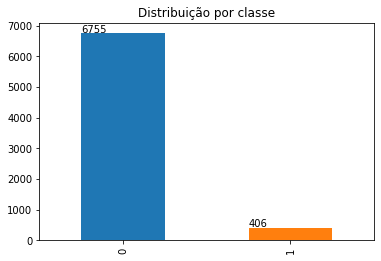

In [12]:
plt.title("Distribuição por classe")
plotData = data["INTRAHOSPITALDEATH"].value_counts()
vDistance = 25
ax = plotData.plot(kind="bar")
ax.set_alpha(0.8)
for i in ax.patches:
    ax.text(i.get_x(), i.get_height() + vDistance, i.get_height())

plt.show()

## Definição dos atributos e da coluna alvo

In [13]:
X = pd.get_dummies(data[data.columns.difference(["ES1", "INTRAHOSPITALDEATH"])])
y = data["INTRAHOSPITALDEATH"]
targetClasses = ["Não", "Sim"]

### Base após aplicação dos dummies

In [14]:
describeData(X)

Colunas: 183


,ACTIVEENDOCARDITIS_B,AGEPAT,ANGORCLASSECCS,BMI,CLEARANCE,CLEARANCECOCK,COPDEUROSC_A,CREATININE,CRITICALPREOPERATIVESTATE_A,D30DEATH,DIABETESONINSULIN,EXTRACARDIAC ARTERIOPATHY_A,GENDERPAT_A,HEIGHT,LVEF,NEUROLOGIC DYSFUNCTION_A,NUMBER,NYHACLASS,PROCEDURE,PULMONARYHYPERTENSION,RECENTMI_A,RENALIMPAIRMENT,SURG,SURGERYTHORACICAORTA,URGENCY_A,WEIGHT,aa,aa2,delaimi,lv1,lv2,mi,redo,ua,PREVIOUSRADIOTHERAPY_No,PREVIOUSRADIOTHERAPY_Yes,ACS<>_< 7 D,ACS<>_< 90 D,ACS<>_> 90 D,ACTIVEENDOCARDITIS_No,ACTIVEENDOCARDITIS_yes,AORTIC_Autogreffe,AORTIC_Bioprosthesis,AORTIC_Homograft,AORTIC_Mechanical,AORTIC_No,AORTIC_valve repair,ARTERIAL HYPERTENSION_No,ARTERIAL HYPERTENSION_Yes,ASCENDINGAORTA_Aneurysm,ASCENDINGAORTA_Dissection,ASCENDINGAORTA_No,ASCENDINGAORTASURGERY_Ascending and arch,ASCENDINGAORTASURGERY_Ascending aorta+aortic valve repair,ASCENDINGAORTASURGERY_Ascending aorta-valve repair,ASCENDINGAORTASURGERY_Ascending+aortic valve,ASCENDINGAORTASURGERY_Bentall bio,ASCENDINGAORTASURGERY_Bentall bio+FOP,ASCENDINGAORTASURGERY_Bentall bio+PAC,ASCENDINGAORTASURGERY_Bentall bio+RVM,ASCENDINGAORTASURGERY_Bentall bio+RVM+p,ASCENDINGAORTASURGERY_Bentall bio+plast,ASCENDINGAORTASURGERY_Bentall mec,ASCENDINGAORTASURGERY_No,ASCENDINGAORTASURGERY_ascending aorta,ASCENDINGAORTASURGERY_ascending aorta +mitral valve,ASCENDINGAORTASURGERY_ascending aorta-CABG,CABG_No,CABG_Yes,CARDIAC RHYTHM_FA ou TSV,CARDIAC RHYTHM_Sinusal,CARDIACFAILURE_No,CARDIACFAILURE_Yes,CIRRHOSIS_No,CIRRHOSIS_PHT,CIRRHOSIS_Uncomplicated,CONGENITALHEARTDISEASE_No,CONGENITALHEARTDISEASE_Yes,COPD_No,COPD_Untreaded,COPD_Yes treated,CORONARY ARTERY DISEASE_No,CORONARY ARTERY DISEASE_Non STEMI,CORONARY ARTERY DISEASE_STEMI,CORONARY ARTERY DISEASE_Stable angina,CORONARYARTERYDISEASE_No,CORONARYARTERYDISEASE_yes,DIABETES STATUS_Insulin,DIABETES STATUS_No,DIABETES STATUS_oral therapy,DYSLIPIDEMIA_No,DYSLIPIDEMIA_Yes,EXTRACARDIAC ARTERIOPATHY_Carotid >50%,EXTRACARDIAC ARTERIOPATHY_Lower Limbs,EXTRACARDIAC ARTERIOPATHY_No,EXTRACARDIAC ARTERIOPATHY_Previous vascular surgery,MITRAL_Bioprosthesis,MITRAL_Mechanical,MITRAL_No,MITRAL_Valve repair,MITRAL_valve repair,NEOPLASIA_<5years,NEOPLASIA_No,NEOPLASIA_metatstasis,NEOPLASIA_no metatstasis,NEUROLOGIC DYSFUNCTION_No,NEUROLOGIC DYSFUNCTION_Yes,ON DIALYSIS_No,ON DIALYSIS_Yes,OTHERS_DISSECTION TYPE B,OTHERS_Dissection,OTHERS_No,OTHERS_Others,OTHERS_Pericarditis,OTHERS_Transplantation,OTHERS_Tumor,OTHERS.1_AF,OTHERS.1_Congenital,OTHERS.1_Myomectomy,OTHERS.1_No,OTHERS.1_Others,OTHERS.1_POF,OTHERS.1_Tumor,POLYVALVULOPATHY_No,POLYVALVULOPATHY_Yes,PREVIOUS CARDIAC FAILURE_No,PREVIOUS CARDIAC FAILURE_Yes,PREVIOUS CARDIAC SURGERY_CABG,PREVIOUS CARDIAC SURGERY_Combined,PREVIOUS CARDIAC SURGERY_No,PREVIOUS CARDIAC SURGERY_Others,PREVIOUS CARDIAC SURGERY_Valvular,PREVIOUS ENDOCARDITIS_No,PREVIOUS ENDOCARDITIS_Yes,PREVIOUS STROKE_Hemorragic stroke,PREVIOUS STROKE_Ischemic stroke,PREVIOUS STROKE_No,PREVIOUS STROKE_TIA,PREVIOUSANGIOPLASTY_No,PREVIOUSANGIOPLASTY_Yes,PREVIOUSEMBOLICEVENT_No,PREVIOUSEMBOLICEVENT_Peripheral,PREVIOUSEMBOLICEVENT_Stroke,PREVIOUSEMBOLICEVENT_Thrombosis,PREVIOUSEMBOLICEVENT_Visceral,REDO_A_ bioproth. failure,REDO_A_Autre,REDO_A_CABG,REDO_A_Endocarditis,REDO_A_Mitral valve repair failure,REDO_A_No,REDO_A_Prosthetic valve thrombosis,REDO_A_Yes,SINGLEVALVULOPATHY_Ao stenosis,SINGLEVALVULOPATHY_AoI,SINGLEVALVULOPATHY_Mitral stenosis,SINGLEVALVULOPATHY_No,SINGLEVALVULOPATHY_Org MR,SINGLEVALVULOPATHY_Tricuspid,SINGLEVALVULOPATHY_fctl MR,SMOKER_Current,SMOKER_No,SMOKER_Past,SMOKER_Unknown,TRICUSPID_No,TRICUSPID_Yes,TRISCUPID_Bioprosthesis,TRISCUPID_Homograft,TRISCUPID_Mechanical,TRISCUPID_No,TRISCUPID_valve repair,ULCER_No,ULCER_Yes,URGENCY_No,URGENCY_Yes,VALVULARSURGERY_No,VALVULARSURGERY_Yes,VALVULOPATHY_No,VALVULOPATHY_Yes,WEIGHTOFPROC_2 procedures,WEIGHTOFPROC_3 procedures,WEIGHTOFPROC_Isolated CABG,WEIGHTOFPROC_single non CABG
count,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,71

## Separação em treino e teste (70% / 30%)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

## Definição dos modelos

In [18]:
svc = SVC(kernel="poly",
          C=1,
          gamma=10,
          degree=4,
          decision_function_shape="ovr")

lr = LogisticRegression(solver="liblinear", multi_class="ovr")

dtc = DecisionTreeClassifier(criterion="entropy")

mn = nb.MultinomialNB()

cpl = nb.ComplementNB()

gau = nb.GaussianNB()

## Treinamento Holdout

In [19]:
yPredSVM = fitAndPredict(svc, X_train, y_train, X_test)
yPredMultinomial = fitAndPredict(mn, X_train, y_train, X_test)
yPredComplement = fitAndPredict(cpl, X_train, y_train, X_test)
yPredGaussian = fitAndPredict(gau, X_train, y_train, X_test)
yPredLogisticRegression = fitAndPredict(lr, X_train, y_train, X_test)
yPredDecisionTree = fitAndPredict(dtc, X_train, y_train, X_test)

## Predição

## Regressão Logística

Acurácia 0.99
----------
Precisão
Não 0.99
Sim 0.97
----------
Revocação
Não 1.00
Sim 0.84
----------
F-Medida
Não 0.99
Sim 0.90
----------


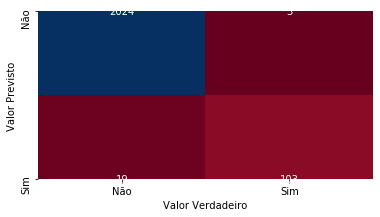

In [27]:
printResults(y_test, yPredLogisticRegression, targetClasses)

## Decision Tree

Acurácia 0.98
----------
Precisão
Não 0.99
Sim 0.79
----------
Revocação
Não 0.99
Sim 0.84
----------
F-Medida
Não 0.99
Sim 0.82
----------


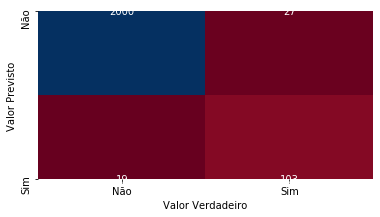

In [29]:
printResults(y_test, yPredDecisionTree, targetClasses)

## SVM

Acurácia 0.96
----------
Precisão
Não 0.99
Sim 0.64
----------
Revocação
Não 0.97
Sim 0.79
----------
F-Medida
Não 0.98
Sim 0.70
----------


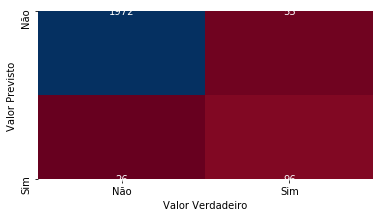

In [30]:
printResults(y_test, yPredSVM, targetClasses)

## MultinomialNB

Acurácia 0.76
----------
Precisão
Não 0.98
Sim 0.15
----------
Revocação
Não 0.76
Sim 0.72
----------
F-Medida
Não 0.86
Sim 0.25
----------


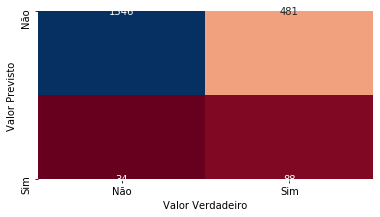

In [31]:
printResults(y_test, yPredMultinomial, targetClasses)

## ComplementNB

Acurácia 0.72
----------
Precisão
Não 0.98
Sim 0.14
----------
Revocação
Não 0.72
Sim 0.74
----------
F-Medida
Não 0.83
Sim 0.23
----------


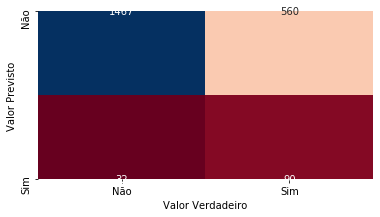

In [32]:
printResults(y_test, yPredComplement, targetClasses)

## GaussianNB

Acurácia 0.50
----------
Precisão
Não 1.00
Sim 0.10
----------
Revocação
Não 0.47
Sim 0.99
----------
F-Medida
Não 0.64
Sim 0.18
----------


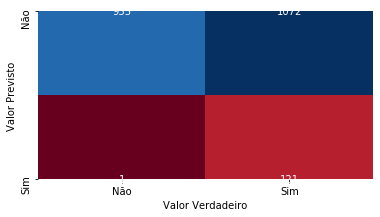

In [33]:
printResults(y_test, yPredGaussian, targetClasses)

## Treinamento Validaçao Cruzada

## Regressão Logística

In [34]:
printCrossValidate(lr, X_train, y_train)

test_accuracy: 0.987628 (+/- 0.003381)
train_accuracy: 0.988128 (+/- 0.000751)
test_precision: 0.987732 (+/- 0.003355)
train_precision: 0.988277 (+/- 0.000732)
test_recall: 0.987628 (+/- 0.003381)
train_recall: 0.988128 (+/- 0.000751)
test_f1: 0.986873 (+/- 0.003746)
train_f1: 0.987468 (+/- 0.000843)


## Decision Tree

In [35]:
printCrossValidate(dtc, X_train, y_train)

test_accuracy: 0.975655 (+/- 0.004850)
train_accuracy: 1.000000 (+/- 0.000000)
test_precision: 0.975996 (+/- 0.005222)
train_precision: 1.000000 (+/- 0.000000)
test_recall: 0.975655 (+/- 0.004850)
train_recall: 1.000000 (+/- 0.000000)
test_f1: 0.975767 (+/- 0.004963)
train_f1: 1.000000 (+/- 0.000000)


## SVM

In [36]:
printCrossValidate(svc, X_train, y_train)

test_accuracy: 0.961893 (+/- 0.007281)
train_accuracy: 0.999900 (+/- 0.000200)
test_precision: 0.964765 (+/- 0.006694)
train_precision: 0.999900 (+/- 0.000200)
test_recall: 0.961893 (+/- 0.007281)
train_recall: 0.999900 (+/- 0.000200)
test_f1: 0.963032 (+/- 0.006854)
train_f1: 0.999900 (+/- 0.000200)
